In [ ]:
# test on an dummy GRD IW product
import xsar
filename = xsar.get_test_file('S1A_IW_GRDH_1SDV_20170907T103020_20170907T103045_018268_01EB76_Z010.SAFE')
outdir = "/tmp/"
config_path = "/home/vincelhx/Documents/autoentreprise/IFREMER/libs/fork_grdwi/grdwindinversion/grdwindinversion/config_prod_streaks.yaml"
overwrite = True
resolution = '1000m'

In [ ]:
import logging
logger = logging.getLogger('grdwindinversion.gradientFeatures')
logger.setLevel(logging.DEBUG)

## preprocess & load config

In [ ]:
from grdwindinversion.inversion import preprocess 

In [ ]:
xr_dataset, out_file, config = preprocess(
    filename, outdir, config_path, overwrite, False, resolution)

model_co = config["l2_params"]["model_co"]
model_cross = config["l2_params"]["model_cross"]
copol = config["l2_params"]["copol"]
crosspol = config["l2_params"]["crosspol"]
copol_gmf = config["l2_params"]["copol_gmf"]
crosspol_gmf = config["l2_params"]["crosspol_gmf"]
dual_pol = config["l2_params"]["dual_pol"]
ancillary_name = config["ancillary"]
sensor_longname = config["sensor_longname"]


## process gradients
- in xr_dataset, it will add variables related to heterogeneity mask an
- it will create xr_dataset_streaks

In [ ]:
from grdwindinversion.inversion import process_gradients

if config["add_gradientsfeatures"]:
    xr_dataset, xr_dataset_streaks = process_gradients(
        xr_dataset, config)
else:
    xr_dataset_streaks = None

In [33]:
xr_dataset_streaks

<xarray.Dataset> Size: 28kB
Dimensions:           (line: 11, sample: 16, pol: 2, downscale_factor: 4,
                       window_size: 2)
Coordinates:
    spatial_ref       int64 8B 0
  * line              (line) float64 88B 4.5 1.604e+03 ... 1.44e+04 1.6e+04
  * sample            (sample) float64 128B 4.5 1.604e+03 ... 2.24e+04 2.4e+04
  * pol               (pol) <U2 16B 'VH' 'VV'
  * downscale_factor  (downscale_factor) int64 32B 1 2 4 8
  * window_size       (window_size) int64 16B 1600 3200
Data variables:
    longitude         (line, sample) float64 1kB nan nan nan ... -70.24 -70.4
    latitude          (line, sample) float64 1kB nan nan nan ... 19.66 19.69
    dir_smooth        (line, sample, pol, downscale_factor, window_size) float64 23kB ...
    dir_mean_smooth   (line, sample) float64 1kB nan nan nan ... -200.5 -188.0
    dir_smooth_mean   (line, sample) float64 1kB nan nan nan ... -200.5 -188.0

## Plotting the results

In [ ]:
import numpy as np
def get_uv_from_dir(wdir):
    """
    Get u, v from wind direction
    
    Parameters
    ----------
    wdir : float
        Wind direction in degrees, meteo convention
    
    Returns
    -------
    u : float
        u component of the wind
    v : float
        v component of the wind
    u_norm : float
        Normalized u component of the wind
    v_norm : float
        Normalized v component of the wind  
    """
    u = np.cos(np.radians(270-wdir))
    v = np.sin(np.radians(270-wdir))
    sq_mean = np.sqrt(u**2+v**2)
    return u, v, u/sq_mean, v/sq_mean

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
cmin=0;cmax=30
norm = matplotlib.colors.Normalize(vmin=cmin,vmax=cmax,clip=False)
import os 

#ancillary 
ds = xr_dataset
p1 = int(ds.line.size/16)
p2 = int(ds.sample.size/16)

lons = ds.longitude[::p1,::p2].values.flatten()
lats = ds.latitude[::p1,::p2].values.flatten()
winddir_ancillary = ds.ancillary_wind_direction[::p1,::p2]
u_ancillary, v_ancllary, u_norm_ancillary, v_norm_ancillary = get_uv_from_dir(winddir_ancillary)

longitude = xr_dataset_streaks['longitude'].values
latitude = xr_dataset_streaks['latitude'].values

In [ ]:
def plot_wind_from_streaks(streaks_dir, **kwargs):
    """
    Plot wind from streaks
    
    Parameters
    ----------
    streaks_dir : xr.Dataset
        Dataset containing streaks direction in degrees in meteo convention
    
    **kwargs : dict
        window_size : int
            Size of the window for smoothing the streaks
        downscale_factor : int
            Downscale factor for smoothing the streaks
        pol : str
            Polarization to plot
        varname : str
            Variable name to plot
    """
    
    
    # handle kwargs
    window_size = kwargs.get('window_size', None)
    downscale_factor = kwargs.get('downscale_factor', None)
    pol = kwargs.get('pol', None)
    pol_display = kwargs.get('pol', 'VV')
    varname = kwargs.get('varname', None)
    savefig = kwargs.get('savefig', False)
    savedir = kwargs.get('savedir', './tmp')
    
    # Plot
    fig = plt.figure(figsize=(10, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Calculer les composantes u et v à partir des angles streaks_dir
    u, v, u_norm, v_norm = get_uv_from_dir(streaks_dir)

    # Display streaks direction
    #ax.quiver(longitude, latitude, u_norm, v_norm, edgecolors='k',  norm=norm, pivot= 'mid', scale_units='xy', scale=4., zorder=10, width=0.1/25,transform = ccrs.PlateCarree(), color = 'red', label = 'owiWindStreaks')
    ax.quiver(longitude, latitude, u_norm, v_norm, edgecolors='k',  norm=norm, pivot= 'mid', scale_units='xy', scale=8., zorder=10, width=0.1/25,transform = ccrs.PlateCarree(), color = 'red', label = 'owiWindStreaks')

    # Display ancillary wind direction
    #ax.quiver(lons, lats, u_norm_ancillary, v_norm_ancillary, edgecolors='k',  norm=norm, pivot= 'mid', scale_units='xy', scale=4., zorder=10, width=0.1/25,transform = ccrs.PlateCarree(), color='blue', label = "owiAncillaryWindDirection")
    ax.quiver(lons, lats, u_norm_ancillary, v_norm_ancillary, edgecolors='k',  norm=norm, pivot= 'mid', scale_units='xy', scale=8., zorder=10, width=0.1/25,transform = ccrs.PlateCarree(), color='blue', label = "owiAncillaryWindDirection")

    # Display sigma0 copol
    im = ax.pcolormesh(xr_dataset.longitude,xr_dataset.latitude, xr_dataset.sigma0.sel(pol=pol_display),cmap='gray')
    cbar = plt.colorbar(im, ax =ax)
    cbar.set_label(f'Sigma0, pol = {pol_display}')
    
    # Expand the map by 1 degree in height
    lon_min, lon_max = np.nanmin(lons) - .2, np.nanmax(lons) + .2 
    lat_min, lat_max = np.nanmin(lats) - .2, np.nanmax(lats) + .7
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())


    # Configurer les axes
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal', adjustable='box')

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.set_title(f"{os.path.basename(filename)}\nvarname = {varname}\nwindow size = {window_size} ; downscale_factor = {downscale_factor} ; pol= {pol}")
    legend = ax.legend(facecolor='white', loc = 'upper right')
    legend.set_zorder(100)
    if savefig:
        os.makedirs(savedir, exist_ok=True)
        plt.savefig(os.path.join(savedir, f"wind_streaks_{varname}_{window_size}_{downscale_factor}_{pol}.png"))

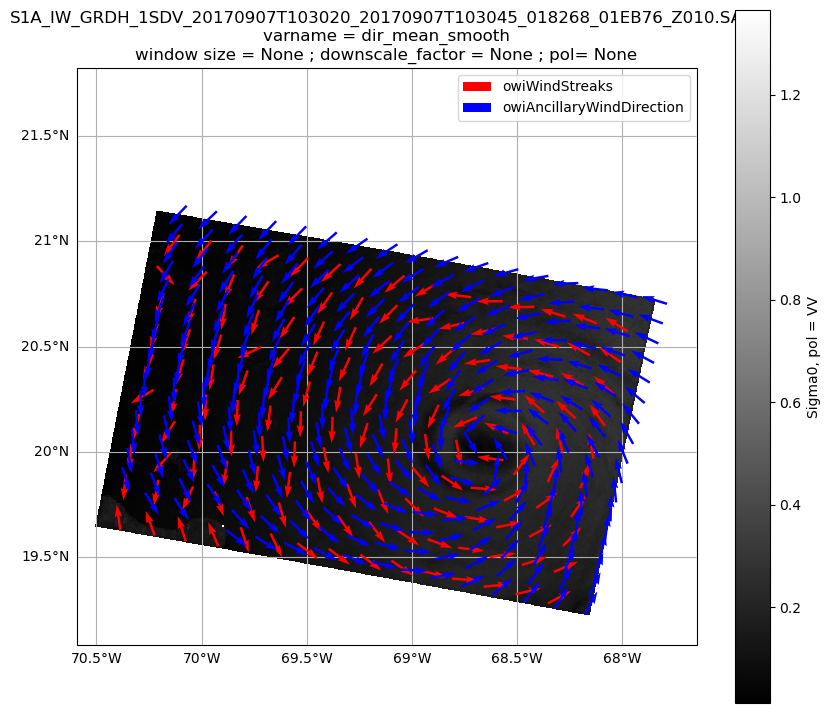

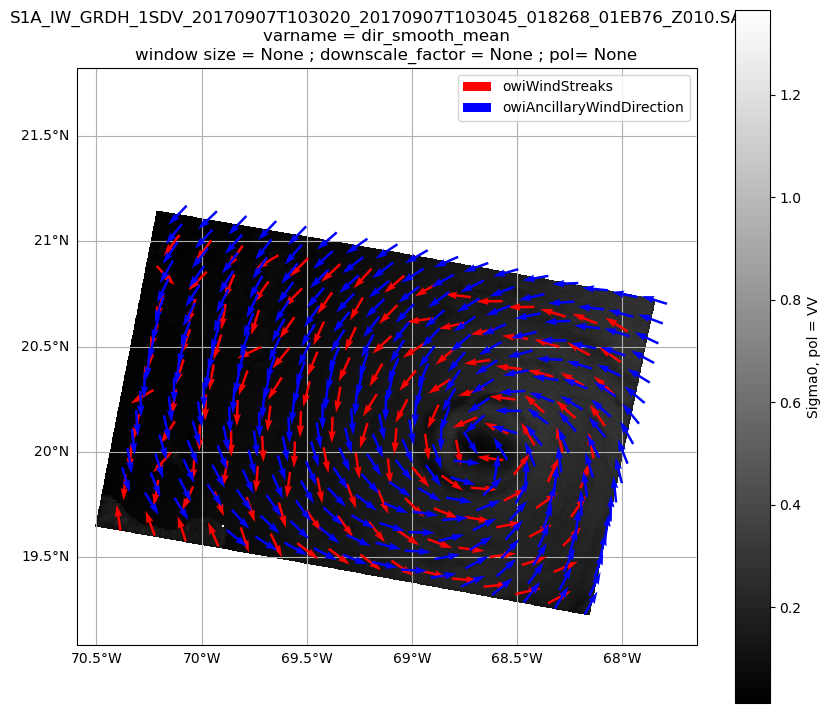

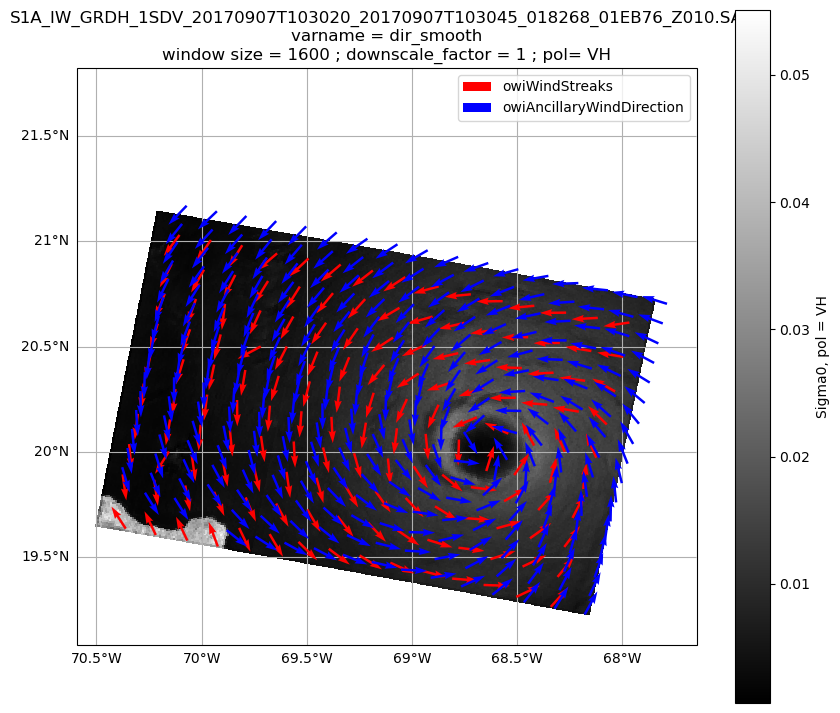

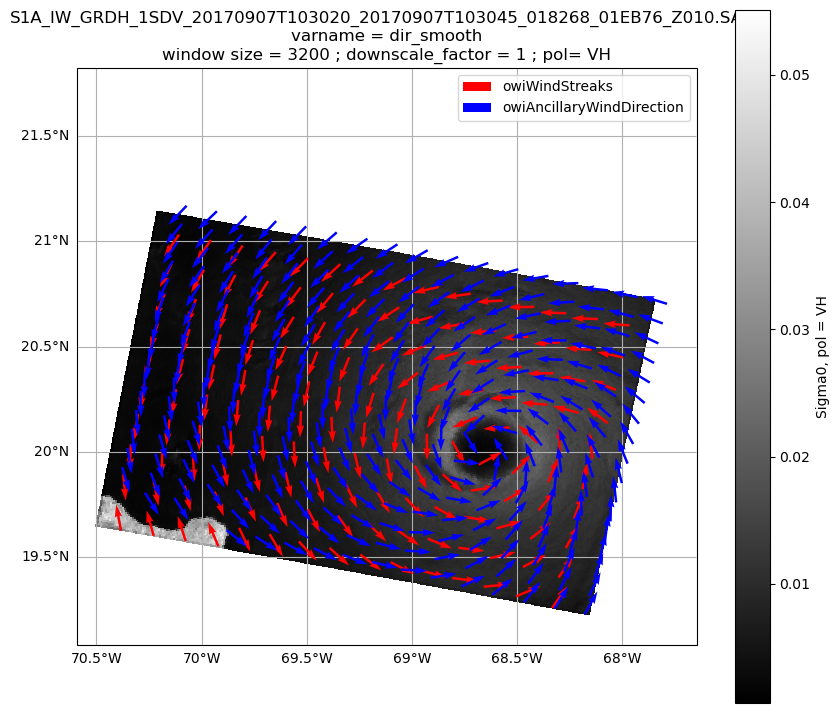

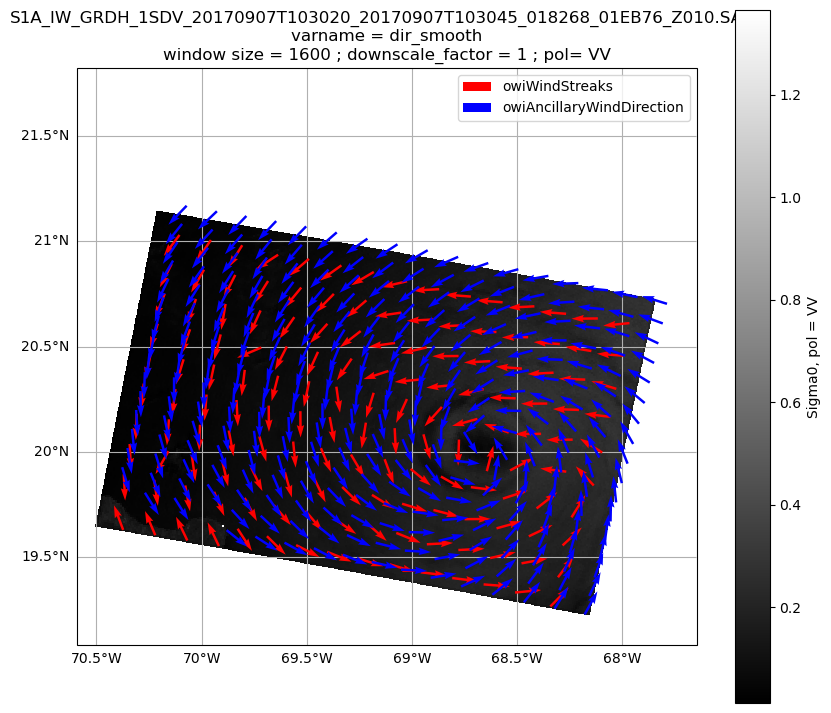

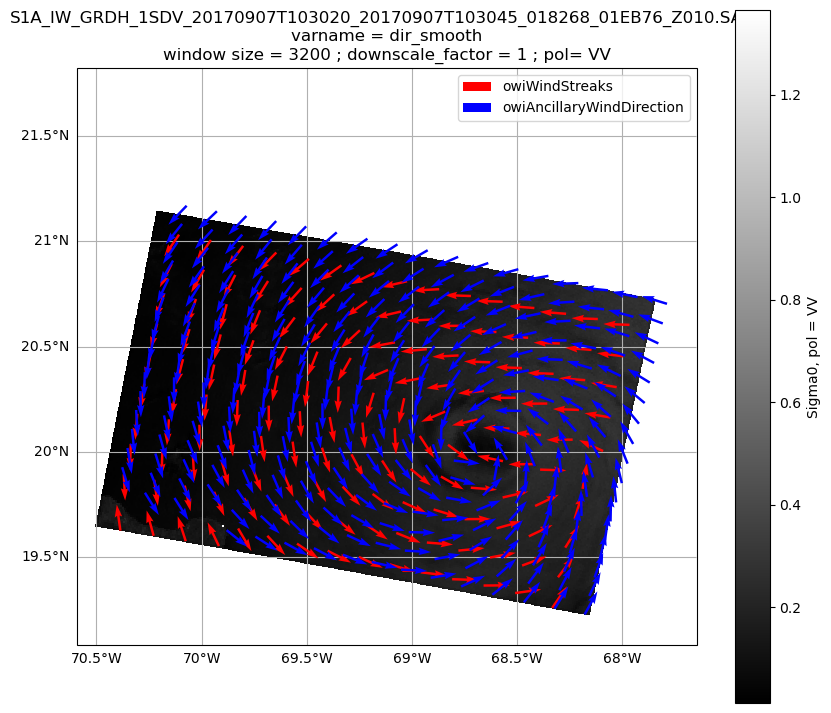

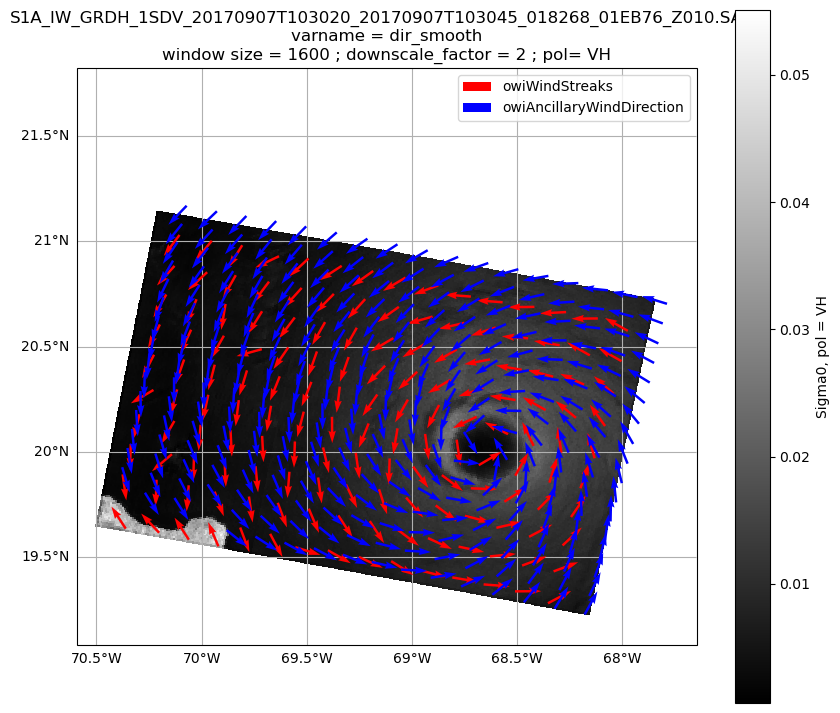

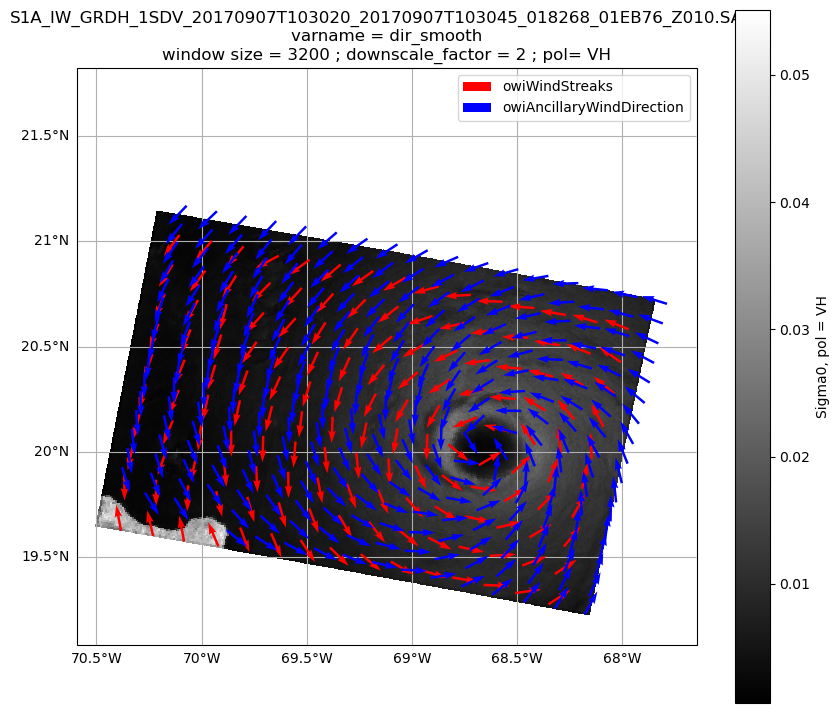

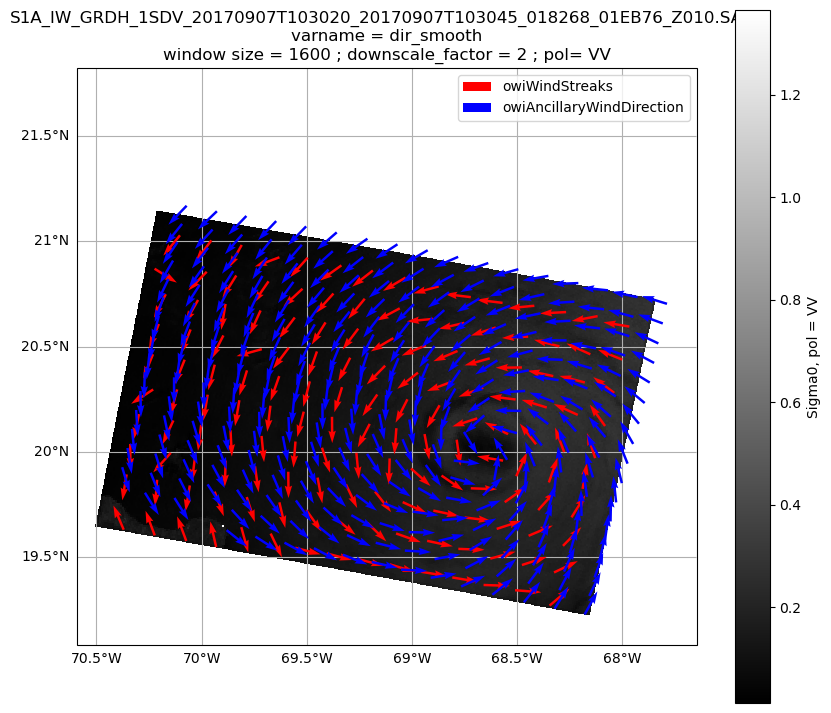

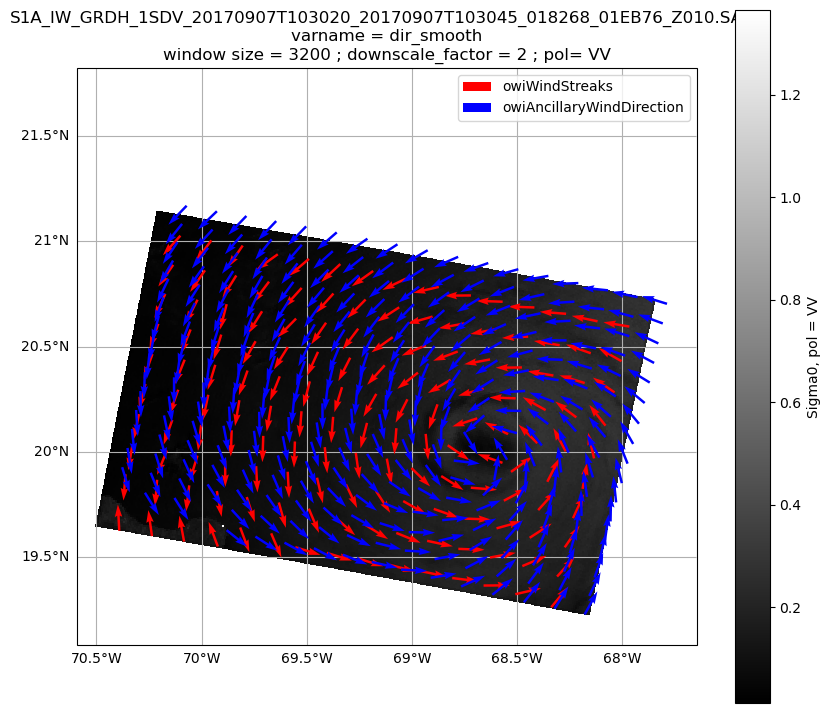

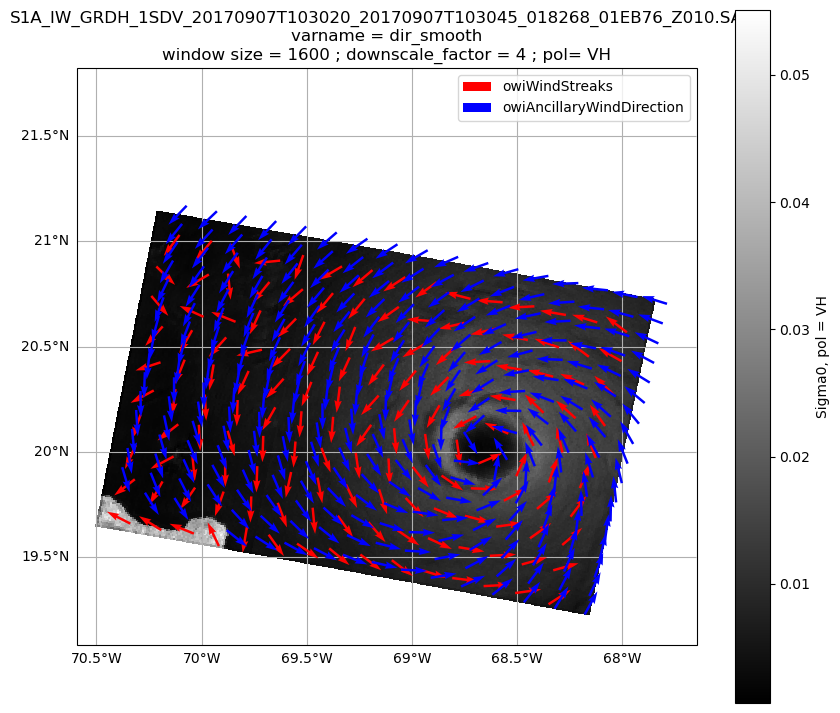

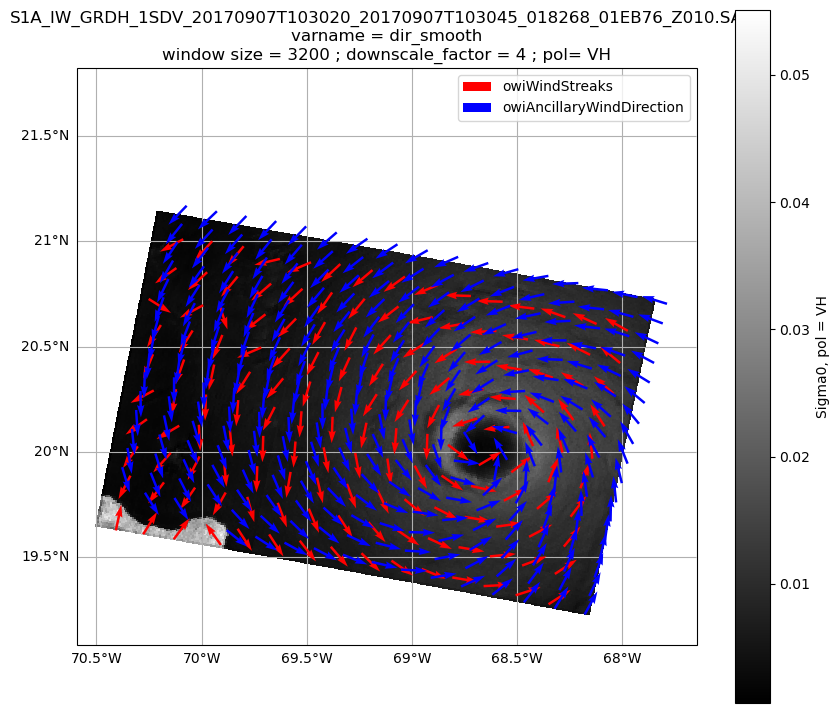

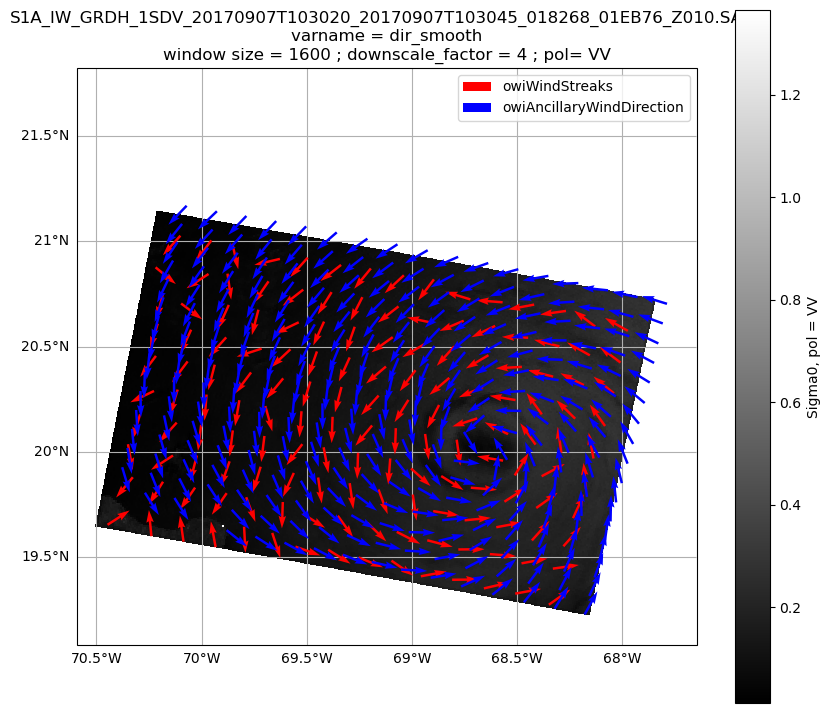

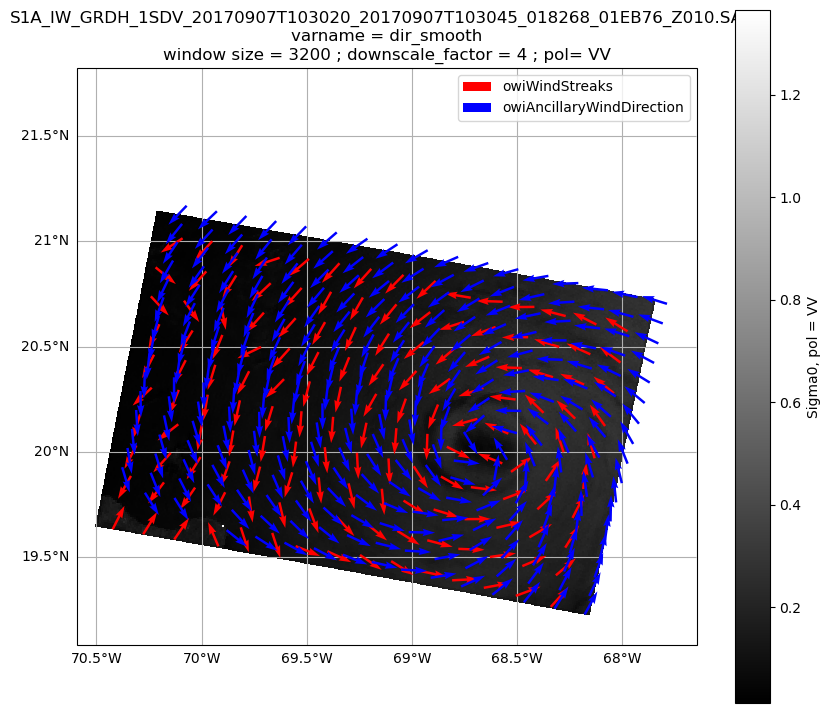

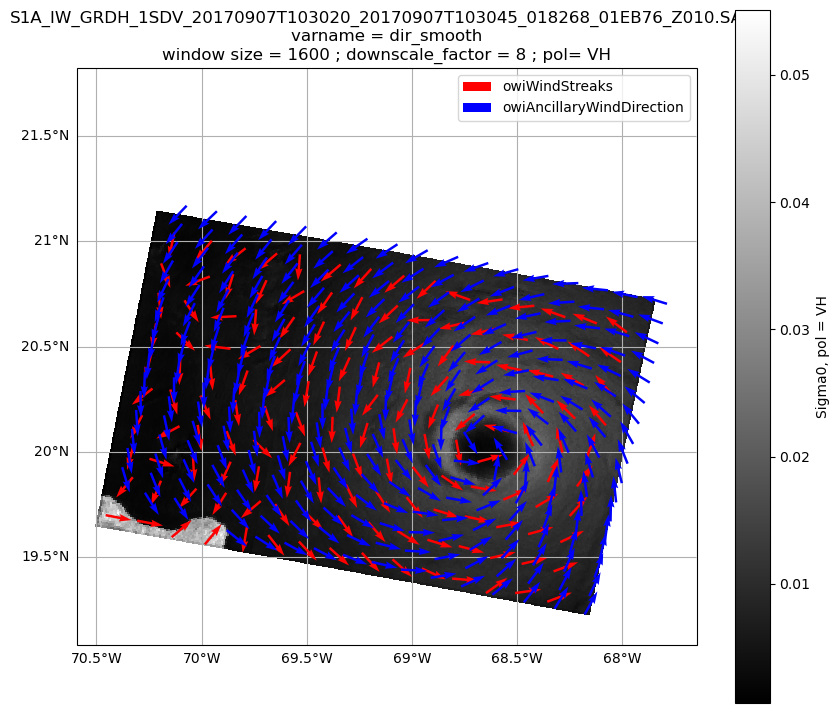

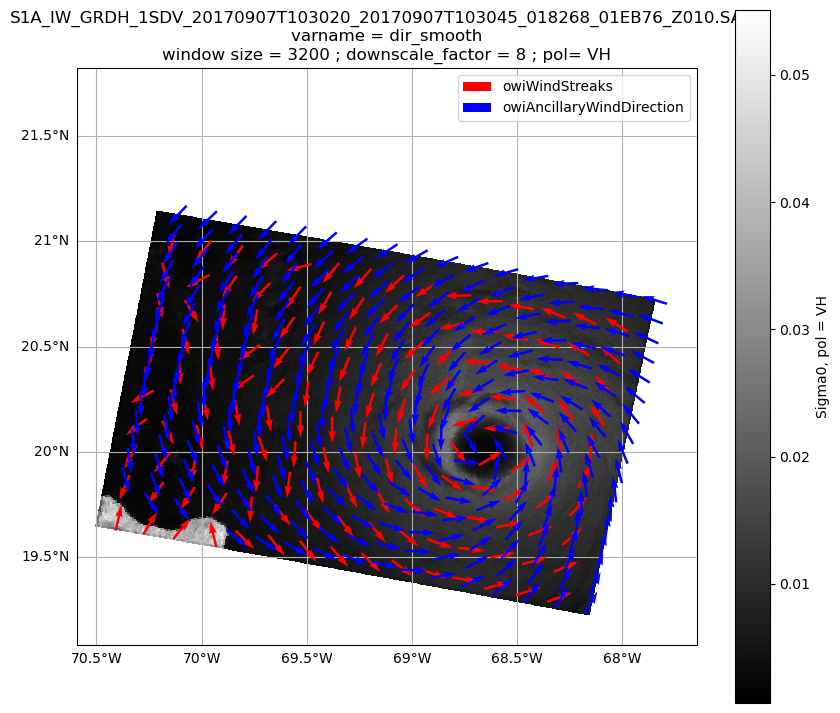

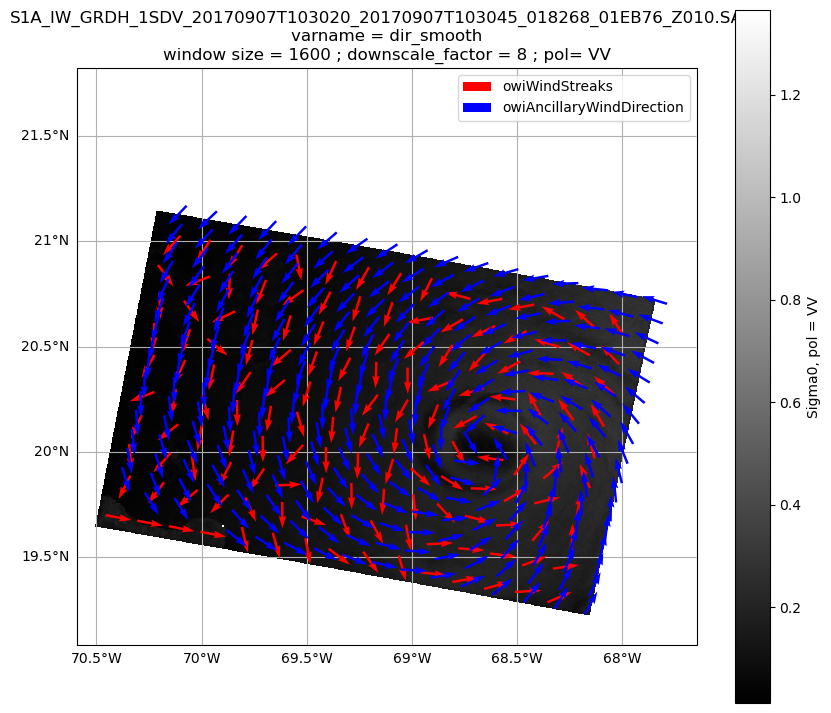

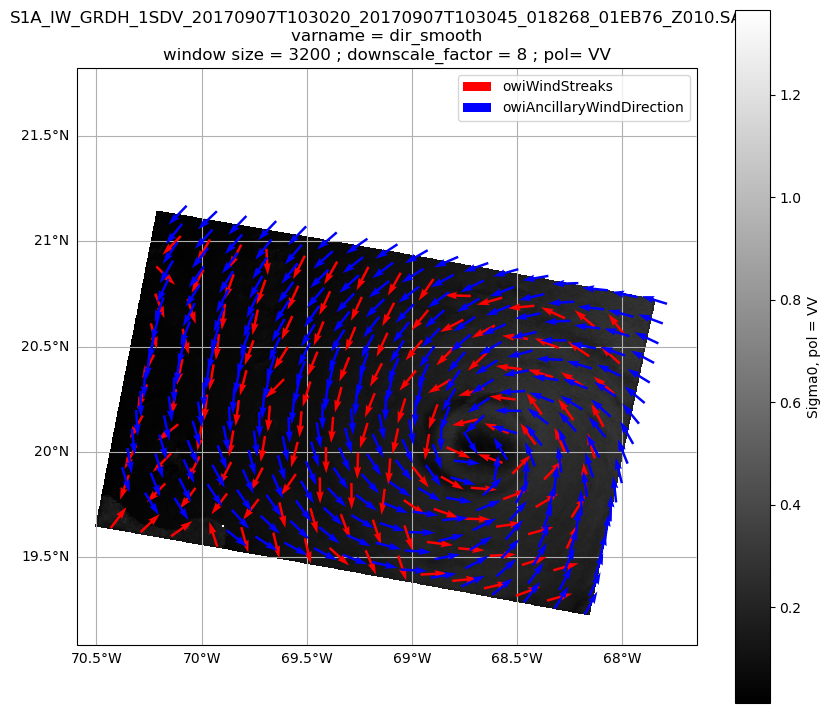

In [32]:
savefig = False

varname = 'dir_mean_smooth'
kwargs = {'varname' : varname, 'savefig': savefig, 'savedir': "./tmp"}
plot_wind_from_streaks(xr_dataset_streaks[varname], **kwargs)

varname = 'dir_smooth_mean'
kwargs = {'varname' : varname, 'savefig': savefig, 'savedir': "./tmp"}
plot_wind_from_streaks(xr_dataset_streaks[varname], **kwargs)


# plot individual solutions 
varname = 'dir_smooth'
for downscale_factor in xr_dataset_streaks.downscale_factor.values:
   for pol in xr_dataset_streaks.pol.values:
       for window_size in xr_dataset_streaks.window_size.values:
           streaks_dir = xr_dataset_streaks[varname].sel(
               downscale_factor=downscale_factor, pol=pol, window_size=window_size).values
           kwargs = {'varname' : varname , 'window_size': window_size, 'downscale_factor': downscale_factor, 'pol': pol, 'savefig': savefig, 'savedir': "./tmp"}
           plot_wind_from_streaks(streaks_dir, **kwargs)

# plot one individual solution
# downscale_factor = 1
# pol = 'VV'
# window_size = 3200

# streaks_dir = xr_dataset_streaks[varname].sel(
#     downscale_factor=downscale_factor, pol=pol, window_size=window_size).values
# kwargs = {'varname' : varname , 'window_size': window_size, 'downscale_factor': downscale_factor, 'pol': pol, 'savefig': True, 'savedir': "./tmp"}
# plot_wind_from_streaks(streaks_dir, **kwargs)

